# Cole-Cole

There are various different definitions of a Cole-Cole model, see for instance Tarasov and Titov (2013). We try a few different ones here, but you can supply your preferred version.

The original Cole-Cole (1940) model was formulated for the complex dielectric permittivity. It is reformulated to conductivity to use it for IP,

$$
\sigma(\omega) = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (i\omega\tau)^C}\ . \qquad\qquad\qquad (1)
$$

Another, similar model is given by Pelton et al. (1978),

$$
\rho(\omega) = \rho_\infty + \frac{\rho_0 - \rho_\infty}{1 + (i\omega\tau)^C}\ . \qquad\qquad\qquad (2)
$$

Equation (2) is just like equation (1), but replaces $\sigma$ by $\rho$. However, mathematically they are not the same. Substituting $\rho = 1/\sigma$ in the latter and resolving it for $\sigma$ will not yield the former. Equation (2) is usually written in the following form, using the chargeability $m = (\rho_0-\rho_\infty)/\rho_0$,

$$
\rho(\omega) = \rho_0 \left[1 - m \left(1- \frac{1}{1 + (i\omega\tau)^C} \right)\right]\ . \quad (3)
$$

In all cases we add the part coming from the dielectric permittivity (displacement currents), even tough it usually doesn't matter in the frequency range of IP.

#### Note: Requires `empymod v1.7.4` or newer.

### References

**Cole, K.S., and R.H. Cole, 1941**, Dispersion and adsorption in dielectrics. I. Alternating current characteristics; *Journal of Chemical Physics*, Volume 9, Pages 341-351, doi: [10.1063/1.1750906](https://doi.org/10.1063/1.1750906).

**Pelton, W.H., S.H. Ward, P.G. Hallof, W.R. Sill, and P.H. Nelson, 1978**, Mineral discrimination and removal of inductive coupling with multifrequency IP, *Geophysics*, Volume 43, Pages 588-609, doi: [10.1190/1.1440839](https://doi.org/10.1190/1.1440839).

**Tarasov, A., and K. Titov, 2013**, On the use of the Cole–Cole equations in spectral induced polarization; *Geophysical Journal International*, Volume 195, Issue 1, Pages 352-356, doi: [10.1093/gji/ggt251](https://doi.org/10.1093/gji/ggt251).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from empymod import bipole, versions
from empymod.utils import _check_var

In [2]:
# Plot-style adjustments
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

## Use `empymod` with a user-defined function to adjust $\eta$ and $\zeta$

In principal it is always best to write your own modelling routine if you want to adjust something. Just copy `empymod.dipole` or `empymod.bipole` as a template, and modify it to your needs. Since `empymod v1.7.4`, however, there
is a hook which allows you to modify $\eta_h, \eta_v, \zeta_h$, and $\zeta_v$ quite easily.

The trick is to provide a dictionary (we name it `inp` here) instead of the resistivity vector in `res`. This dictionary, `inp`, has two mandatory plus optional entries:
- `res`: the resistivity vector you would have provided normally (mandatory).
- A function name, which has to be either or both of (mandatory)
    - `func_eta`: To adjust `etaH` and `etaV`, or
    - `func_zeta`: to adjust `zetaH` and `zetaV`.
- In addition, you have to provide all parameters you use in `func_eta`/`func_zeta` and are not already provided to `empymod`. All additional parameters must have #layers elements.

The functions `func_eta` and `func_zeta` must have the following characteristics:
- The signature is `func(inp, p_dict)`, where
    - `inp` is the dictionary you provide, and
    - `p_dict` is a dictionary that contains all parameters so far calculated in empymod [`locals()`].
- It must return `etaH, etaV` if `func_eta`, or `zetaH, zetaV` if `func_zeta`.

Dummy example
```
def my_new_eta(inp, p_dict):
    # Your calculations, using the parameters you provided
    # in `inp` and the parameters from empymod in `p_dict`.
    # In the example below, we provide, e.g., inp['tau']
    return etaH, etaV
```
And then you call `empymod` with `res={'res': res-array, 'tau': tau, 'func_eta': my_new_eta}`.

## Define the Cole-Cole model

In this notebook we exploit this hook in empymod to calculate $\eta_h$ and $\eta_v$ with the Cole-Cole model. By default, $\eta_h$ and $\eta_v$ are calculated like this:
    
    etaH = 1/res + 2j*np.pi*freq*epermH*epsilon_0
    etaV = 1/(res*aniso**2) + 2j*np.pi*freq*epermV*epsilon_0

With this function we recalculate it. We replace the real part, the conductivity, by the complex, frequency-dependent Cole-Cole conductivity. Then we add back the imaginary part coming from thet dielectric permittivity (basically zero for low frequencies).


In [3]:
def cole_cole(inp, p_dict):
    """Cole and Cole (1941)."""   
    
    # Calculate complex conductivity from Cole-Cole
    iotc = np.outer(2j*np.pi*p_dict['freq'], inp['tau'])**inp['c']
    condH = inp['cond_8'] + (inp['cond_0']-inp['cond_8'])/(1+iotc)
    condV = condH/p_dict['aniso']**2

    # Add electric permittivity contribution
    etaH = condH + 1j*p_dict['etaH'].imag
    etaV = condV + 1j*p_dict['etaV'].imag

    return etaH, etaV


def pelton_et_al(inp, p_dict):
    """ Pelton et al. (1978)."""

    # Calculate complex resistivity from Pelton et al.
    iotc = np.outer(2j*np.pi*p_dict['freq'], inp['tau'])**inp['c']
    rhoH = inp['rho_0']*(1 - inp['m']*(1 - 1/(1 + iotc)))
    rhoV = rhoH*p_dict['aniso']**2

    # Add electric permittivity contribution
    etaH = 1/rhoH + 1j*p_dict['etaH'].imag
    etaV = 1/rhoV + 1j*p_dict['etaV'].imag

    return etaH, etaV

## Example

Two half-space model, air above earth:

- x-directed sourcer at the surface
- x-directed receiver, also at the surface, inline at an offset of 500 m. 
- Switch-on time-domain response
- Isotropic
- Model [air, subsurface]
    - $\rho_\infty = 1/\sigma_\infty =$ [2e14, 10]
    - $\rho_0 = 1/\sigma_0 =$ [2e14, 5]
    - $\tau =$ [0, 1]
    - $c =$ [0, 0.5]

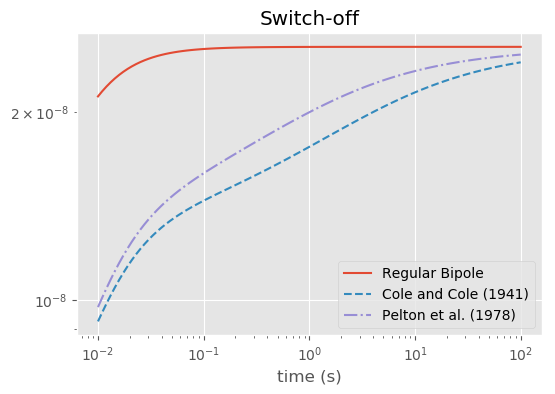

In [4]:
# Times
times = np.logspace(-2, 2, 101)

# Model parameter which apply for all
model = {
    'src': [0, 0, 1e-5, 0, 0],
    'rec': [500, 0, 1e-5, 0, 0],
    'depth': 0,
    'freqtime': times,
    'signal': 1,
    'verb': 1
}

# Collect Cole-Cole models
res_0 = np.array([2e14, 10])
res_8 = np.array([2e14, 5])
tau = [0, 1]
c = [0, 0.5]
m = (res_0-res_8)/res_0

cole_model = {'res': res_0, 'cond_0': 1/res_0, 'cond_8': 1/res_8,
              'tau': tau, 'c': c, 'func_eta': cole_cole}
pelton_model = {'res': res_0, 'rho_0': res_0, 'm': m, 
                'tau': tau, 'c': c, 'func_eta': pelton_et_al}

# Calculate
out_bipole = bipole(res=res_0, **model)
out_cole = bipole(res=cole_model, **model)
out_pelton = bipole(res=pelton_model, **model)

# Plot
plt.figure()
plt.title('Switch-off')
plt.plot(times, out_bipole, label='Regular Bipole')
plt.plot(times, out_cole, '--', label='Cole and Cole (1941)')
plt.plot(times, out_pelton, '-.', label='Pelton et al. (1978)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('time (s)')
plt.show()

In [5]:
versions('HTML')